## Preprocessing script to clean and merge articles from different sources
#### Below you will also find scripts for histogram and jitterplot and simple statistical analysis

In [2]:
import pandas as pd
import json
import re

# File path
file_path = 'articles/filtered_articles.json'

# Load JSON file into DataFrame
try:
    df = pd.read_json(file_path)
    print("JSON loaded successfully.")
except ValueError as e:
    print(f"Error loading JSON: {e}")

# Convert the timestamp to a readable date format
df['date'] = pd.to_datetime(df['date'], unit='ms').dt.strftime('%Y-%m-%d')

# Function to remove escaping backslashes
def remove_escaping_backslashes(text):
    return re.sub(r'\\', '', text)

for e in df:
    for f in e:
        re.sub(r'\\', '', e)

# Save the updated DataFrame to JSON file
df.to_json(file_path, orient='records', lines=False, force_ascii=False, indent=4)

print("Date format updated, backslashes removed, and file saved successfully.")

JSON loaded successfully.
Date format updated, backslashes removed, and file saved successfully.


In [2]:
# Merge all
import glob
import json
from datetime import datetime

def is_valid_date(date_str):
    if date_str is None:
        return True
    try:
        datetime.strptime(date_str, "%d %B %Y")
        return True
    except ValueError:
        return False

def make_date_format(date_str):
    if date_str == None:
        return None
    date_obj = datetime.strptime(date_str, "%B %d, %Y")
    return date_obj.strftime("%d %B %Y")

json_files = glob.glob('articles/*.json')
print(json_files)

all_articles = []

for filepath in json_files:
    with open(filepath, 'r', encoding='utf-8') as file:
        data = json.load(file)
        all_articles.extend(data)

for article in all_articles:
    if not is_valid_date(article['date']):
        article['date'] = make_date_format(article['date'])

with open('articles/all_articles.json', 'w', encoding='utf-8') as file:
    json.dump(all_articles, file, ensure_ascii=False, indent=4)

['articles/NucNet_articles_NEW.json', 'articles/WNN_articles.json', 'articles/NCE_articles.json', 'articles/NEI_articles_NEW.json']


In [21]:
# Data exploration
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

def count_words(paragraphs):
    if paragraphs is None:
        return 0
    return sum(len(paragraph.split()) for paragraph in paragraphs if paragraph)

def get_stats(data, data_type='<data type>'):
    data.loc[:, 'num_words'] = data['text'].apply(count_words)

    num_articles_total = f'{data.shape[0]:,}'
    num_words_total = data.loc[:, 'num_words'].sum()

    rows = data.shape[0]
    cols = f'{data.shape[1]:,}'
    
    earliest = min(data['date']).date()
    latest = max(data['date']).date()

    article_breakdown = data.groupby('magasine').agg(
        num_articles=('text', 'size'),
        total_words=('num_words', 'sum')
    ).reset_index()
    article_breakdown['percentage_articles'] = (article_breakdown['num_articles'] / rows) * 100
    article_breakdown['percentage_words'] = (article_breakdown['total_words'] / num_words_total) * 100

    # Format numbers
    article_breakdown['num_articles'] = article_breakdown['num_articles'].apply(lambda x: f"{x:,}")
    article_breakdown['total_words'] = article_breakdown['total_words'].apply(lambda x: f"{x:,}")
    article_breakdown['percentage_articles'] = article_breakdown['percentage_articles'].apply(lambda x: f"{x:.2f}%")
    article_breakdown['percentage_words'] = article_breakdown['percentage_words'].apply(lambda x: f"{x:.2f}%")
    num_words_formatted = f'{num_words_total:,}'

    print('-'*40)
    print(f'{data_type.upper()}:')
    
    print(f'Total num articles: {num_articles_total:>20}')
    print(f'Total num words: {num_words_formatted:>23}')
    print(f'Earliest date: {str(earliest):>25}')
    print(f'Latest date: {str(latest):>27}')
    print('-'*98)
    print(article_breakdown)
    print('-'*98)

abbrev_map = {
    'New Civil Engineer': 'NCE',
    'Nuclear Engineering International': 'NEI',
    'NucNet': 'NucNet',
    'World Nuclear News': 'WNN'
}

def word_count_jitterplot(data):
    data.loc[:, 'num_words'] = data['text'].apply(count_words)
    category_order = ['NCE', 'NucNet', 'NEI', 'WNN']
    
    data['magazine_abbrev'] = data['magasine'].map(abbrev_map)
    data['magazine_abbrev'] = pd.Categorical(data['magazine_abbrev'], categories=category_order, ordered=True)

    median = data['num_words'].median()

    plt.figure(figsize=(10, 6))
    sns.stripplot(data=data, x='num_words', y='magazine_abbrev', dodge=False, palette='tab20', jitter=0.3, size=3)
    plt.axvline(median, linestyle='--', color='red', label=f'Global Median: {int(median)}')
    plt.xlabel('Word Count')
    plt.ylabel('')
    plt.legend(loc='upper right', frameon=True)

    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0.5) 

    plt.show()

def word_count_histogram(data):
    data.loc[:, 'num_words'] = data['text'].apply(count_words)
    magazine_order = ['NCE', 'NucNet', 'NEI', 'WNN']

    data['magazine_abbrev'] = data['magasine'].map(abbrev_map)
    data['magazine_abbrev'] = pd.Categorical(data['magazine_abbrev'], categories=magazine_order, ordered=True)

    data = data[data['magazine_abbrev'].notna()]  

    magazines = magazine_order  

    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
    axes = axes.flatten()

    min_count = data['num_words'].min()
    max_count = data['num_words'].max()
    bins = np.linspace(min_count, max_count, 31)

    for i, magazine in enumerate(magazines):
        magazine_data = data[data['magazine_abbrev'] == magazine]
        sns.histplot(data=magazine_data, x='num_words', bins=bins, ax=axes[i], kde=False, color=sns.color_palette('tab20')[i])
        median_val = int(magazine_data['num_words'].median())
        article_count = len(magazine_data)
        axes[i].axvline(median_val, linestyle='--', color='red', label=f'Median: {median_val:}')
        axes[i].set_title(f'{magazine} (N = {article_count})')
        axes[i].set_xlabel('Word Count')
        axes[i].set_ylabel('Frequency')
        axes[i].legend()

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


## Simple Statistical Analysis of Text Corpus

In [4]:
import pandas as pd

file_path = 'articles/all_articles.json'

try:
    df = pd.read_json(file_path)
    print("JSON loaded successfully.")
except ValueError as e:
    print(f"Error loading JSON: {e}")
    
print(df.info())

JSON loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7929 entries, 0 to 7928
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   url       7929 non-null   object        
 1   magasine  7929 non-null   object        
 2   title     7905 non-null   object        
 3   author    7489 non-null   object        
 4   date      7905 non-null   datetime64[ns]
 5   text      7905 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 371.8+ KB
None


/var/folders/8l/0_4vn3q5349ch5tr2wj6lzxm0000gp/T/ipykernel_12346/1820570336.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'num_words'] = data['text'].apply(count_words)
/var/folders/8l/0_4vn3q5349ch5tr2wj6lzxm0000gp/T/ipykernel_12346/1820570336.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['magazine_abbrev'] = data['magasine'].map(abbrev_map)
/var/folders/8l/0_4vn3q5349ch5tr2wj6lzxm0000gp/T/ipykernel_12346/1820570336.py:86: SettingWithCopyWarning: 
A value is trying to be set 

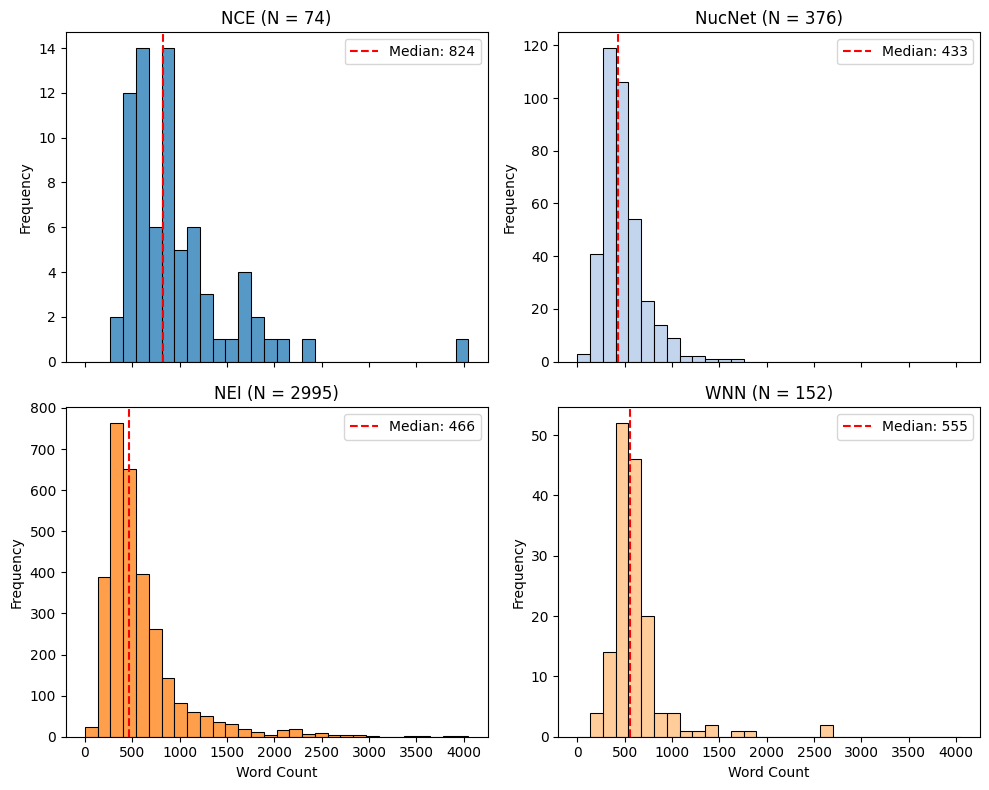

In [22]:
#get_stats(df, 'all scraped')

df['date'] = pd.to_datetime(df['date'])
earliest = pd.to_datetime('2022-06-14')
latest = pd.to_datetime('2024-06-14')

df_updated = df[(df['date'] >= earliest) & (df['date'] <= latest)]

#get_stats(df_updated, 'last two years')
#word_count_jitterplot(df_updated)
word_count_histogram(df_updated)

# Save updated file
#df_updated.to_json('articles/filtered_articles.json', orient='records', lines=False, force_ascii=False, indent=4)

In [6]:
import random
import numpy as np
import pandas as pd

def split_data(data, train_frac=.70, test_frac=.15, validation_frac=.15, random_seed=None):

    if random_seed is not None:
        np.random.seet(random_seed)

    total_length = data.shape[0]
    indices = np.random.permutation(total_length)

    train_cutoff = int(total_length*train_frac)
    test_cutoff = train_cutoff + int(total_length*test_frac)

    train_indices = indices[:train_cutoff]
    test_indices = indices[train_cutoff:test_cutoff]
    validation_indices = indices[test_cutoff:]

    train = data.iloc[train_indices]
    test = data.iloc[test_indices]
    validation = data.iloc[validation_indices]
    
    print('DATA SPLIT:')
    print(f'Train Data Shape:         {train.shape}')
    print(f'Test Data Shape:          {test.shape}')
    print(f'Validation Data Shape:    {validation.shape}')

    return train, test, validation

In [7]:
train, test, validation = split_data(df_updated)

get_stats(train, 'train')
get_stats(test, 'test')
get_stats(validation, 'validation')

DATA SPLIT:
Train Data Shape:         (5035, 7)
Test Data Shape:          (1079, 7)
Validation Data Shape:    (1080, 7)
----------------------------------------
TRAIN:
Total num articles:                5,035
Total num words:               2,948,390
Earliest date:                2022-06-14
Latest date:                  2024-06-14
--------------------------------------------------------------------------------------------------
                            magasine num_articles total_words percentage_articles percentage_words
0                 New Civil Engineer          111     103,032               2.20%            3.49%
1                             NucNet          515     247,958              10.23%            8.41%
2  Nuclear Engineering International        4,187   2,458,573              83.16%           83.39%
3                 World Nuclear News          222     138,827               4.41%            4.71%
--------------------------------------------------------------------------